In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!pip install -U segmentation-models

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
from google.colab import drive
from datetime import datetime
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, Accuracy, MeanIoU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import pickle
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


### Connecting with Google Drive and paths setting

In [ ]:
# Mount the google drive in notebook sources
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/data/augmented" "/content/data/"

# Base path to the processed HRSID data
base_path = '/content/data/'

# Path to all saved models
models_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models'

NameError: name 'drive' is not defined

## Model preparation & training

### Defining the data generator

In [ ]:
class SARDataGenerator(Sequence):
    """
    Data generator for loading and processing images and masks on the fly.
    This class is derived from Keras's Sequence class to efficiently handle
    batching in multi-threaded environments.
    """

    def __init__(self, image_filenames, masks_filenames, batch_size, target_size, backbone, augmentations=None, shuffle=True):
        """
        Initialize the data generator instance.
        """
        self.image_filenames = image_filenames
        self.masks_filenames = masks_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.preprocess_input = sm.get_preprocessing(backbone)
        self.augmentations = augmentations
        self.shuffle = shuffle

        if augmentations is not None:
            self.datagen = ImageDataGenerator(**augmentations)
        else:
            self.datagen = ImageDataGenerator()

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Generate one batch of data.
        """
        # Slice the file paths to generate the batch
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Load and process the images and masks
        images = [self.process_image(file_name) for file_name in batch_x]
        masks = [self.process_mask(file_name) for file_name in batch_y]

        # Augment the images and masks
        seed = np.random.randint(0, 10000)
        images = next(self.datagen.flow(np.array(images), batch_size=self.batch_size, seed=seed))
        masks = next(self.datagen.flow(np.array(masks), batch_size=self.batch_size, seed=seed))

        # Extra preprocessing to fit specific backbone
        images = self.preprocess_input(images)
        masks = self.preprocess_input(masks)

        return images, masks

    def on_epoch_end(self):
        """
        Shuffles the order of data at the end of each epoch if shuffle is enabled.
        """
        if self.shuffle:
            temp = list(zip(self.image_filenames, self.masks_filenames))
            np.random.shuffle(temp)
            self.image_filenames, self.masks_filenames = zip(*temp)
            self.image_filenames = list(self.image_filenames)
            self.masks_filenames = list(self.masks_filenames)


    def process_image(self, file_name):
        """
        Load and process an image file.
        """
        if len(self.target_size) == 3 and self.target_size[2] == 3:
            image = load_img(file_name, target_size=self.target_size, color_mode='rgb')
        else:
            image = load_img(file_name, target_size=self.target_size, color_mode='grayscale')
        image = img_to_array(image) / 255.0

        return image

    def process_mask(self, file_name):
        """
        Load and process a mask file.
        """
        mask = load_img(file_name, target_size=self.target_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0

        return mask

### Defining los function

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

### Creating directory for model data

In [ ]:
# Create a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# Combine the models path with the timestamp
model_dir = os.path.join(models_path, f'Sesja z {timestamp}')
# Create the directory
os.makedirs(model_dir, exist_ok=True)
print(f"New directory created: {model_dir}")

NameError: name 'datetime' is not defined

### Defining callbacks

In [ ]:
callback_1 = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'unet_best_val_loss.keras'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callback_2 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_precision.keras"),
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_3 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_recall.keras"),
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_4 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_accuracy.keras"),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_5 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_iou.keras"),
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True,
    verbose=1
)

### Defining training parameters

In [ ]:
BACKBONE = 'resnet34'
N_CLASSES = 2
LEARNING_RATE = 5e-5
TARGET_SHAPE = (512, 512, 3)
BATCH_SIZE = 16
EPOCHS = 20

### Building U-Net model

In [ ]:
opti = Adam(learning_rate=LEARNING_RATE)

model = sm.Unet(backbone_name=BACKBONE, classes=N_CLASSES-1, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer=opti, loss=dice_loss, metrics=[Precision(), Recall(), Accuracy(), MeanIoU(num_classes=N_CLASSES)])
model.summary()

85521592/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                           

### Creating generator objects

In [ ]:
train_images_dir = os.path.join(base_path, 'train', 'images')
train_masks_dir = os.path.join(base_path, 'train', 'masks')
train_images = [os.path.join(train_images_dir, f) for f in sorted(os.listdir(train_images_dir))]
train_masks = [os.path.join(train_masks_dir, f) for f in sorted(os.listdir(train_masks_dir))]

val_images_dir = os.path.join(base_path, 'val', 'images')
val_masks_dir = os.path.join(base_path, 'val', 'masks')
val_images = [os.path.join(val_images_dir, f) for f in sorted(os.listdir(val_images_dir))]
val_masks = [os.path.join(val_masks_dir, f) for f in sorted(os.listdir(val_masks_dir))]

augmentations = {
    'rotation_range': 10,              # Small rotations
    'width_shift_range': 0.05,          # Slight horizontal shifts
    'height_shift_range': 0.05,         # Slight vertical shifts
    'shear_range': 0.05,               # Small shear transformations
    'zoom_range': [0.8, 1.0],                 # Small zooms in and out
    'horizontal_flip': True,           # Horizontal flips (if applicable)
    'vertical_flip': True,             # Vertical flips (if applicable)
    'fill_mode': 'constant'            # Fill mode for new pixels
}

train_gen = SARDataGenerator(image_filenames=train_images, masks_filenames=train_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE, backbone=BACKBONE)
val_gen = SARDataGenerator(image_filenames=val_images, masks_filenames=val_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE, backbone=BACKBONE)

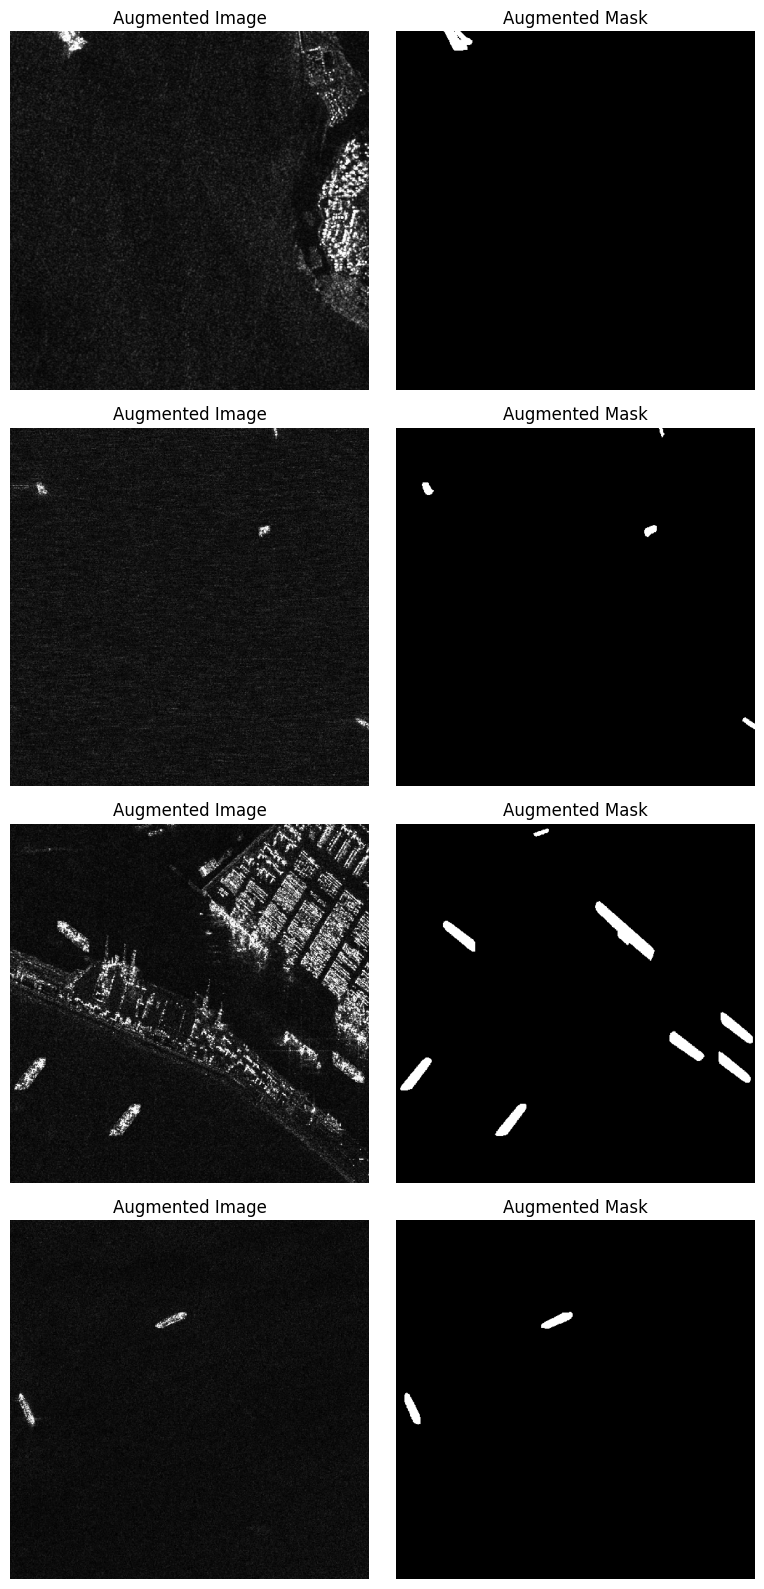

In [ ]:
# Function to visualize a few random augmented images and masks
def visualize_augmentations(generator, num_samples=4):
    images, masks = generator.__getitem__(4)  # Get the first batch

    plt.figure(figsize=(8, num_samples * 4))

    for i in range(num_samples):
        # Display augmented image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Augmented Image')
        plt.axis('off')

        # Display augmented mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the augmentations
visualize_augmentations(train_gen, num_samples=4)

### Training the model

In [ ]:
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    validation_data=val_gen,
                    callbacks=[callback_1, callback_2, callback_3, callback_4, callback_5])

NameError: name 'model' is not defined

### Saving training history

In [ ]:
with open(os.path.join(model_dir, 'training_history.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

## Model evaluation

### Loading the model and history of training

In [ ]:
saved_model = model
saved_history = history.history

In [ ]:
model_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-18_11-26-49/unet_best_val_loss.keras'
history_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-18_11-26-49/training_history.pkl'

# Load the saved model
saved_model = load_model(model_path, custom_objects={'dice_loss': dice_loss})

# Load the saved history
with open(history_path, 'rb') as file:
    saved_history = pickle.load(file)

### Historical metrics and losses from training

In [ ]:
def plot_training_history(hist_dict):
    data_cats = list(hist_dict.keys())
    valid_data = sorted([d for d in data_cats if 'val_' in d])
    train_data = sorted([d for d in data_cats if 'val_' not in d])
    data_pairs = list(zip(train_data, valid_data)) if len(valid_data) else [(d) for d in train_data]

    for data in data_pairs:
        fig, axs = plt.subplots(figsize=(6, 5))
        fig.suptitle(f"{data[0].capitalize().replace('_', ' ')} over training epochs")
        y_values = hist_dict[data[0]]
        x_values = range(1, len(y_values) + 1)
        axs.plot(x_values, y_values, label="training", color='blue', marker='o', linewidth=2)
        if len(data) > 1:
            y_values = hist_dict[data[1]]
            axs.plot(x_values, y_values, label="validation", color='orange', marker='o', linewidth=2)
        axs.set_xlabel('epochs')
        axs.set_ylabel(f"{data[0].replace('_', ' ').lower()}")
        axs.xaxis.set_major_locator(MaxNLocator(integer=True))
        axs.legend()
        axs.grid()
        plt.show()

Data categories from model training:  ['loss', 'precision', 'recall', 'accuracy', 'mean_io_u', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy', 'val_mean_io_u'] 



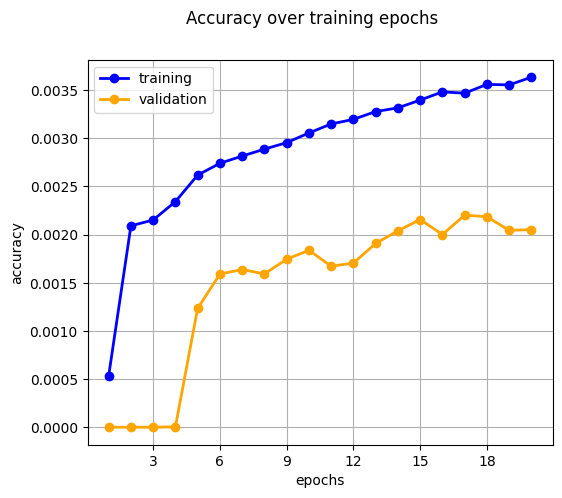

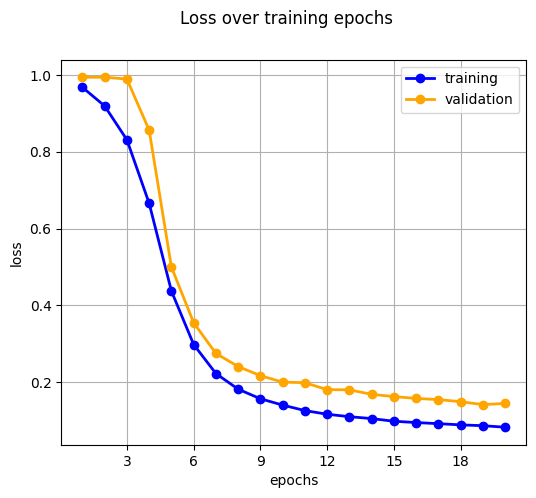

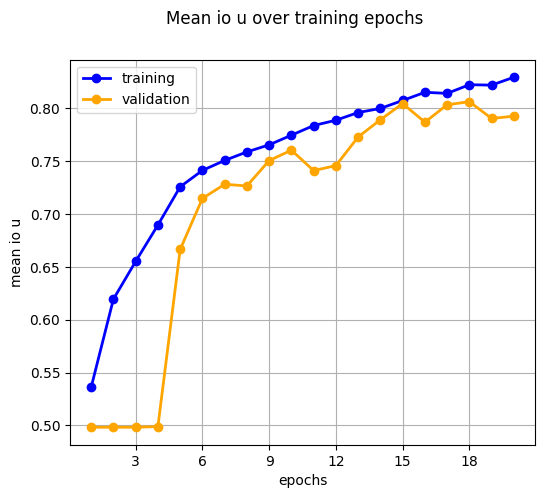

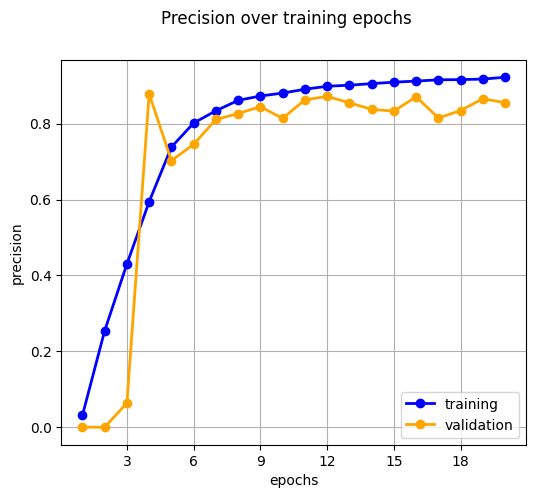

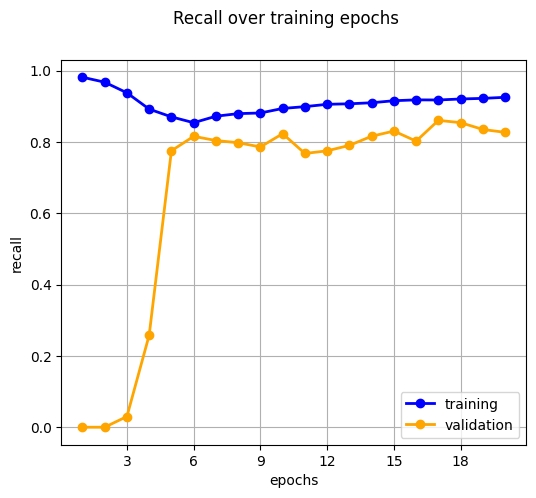

In [ ]:
print("Data categories from model training: ", list(saved_history.keys()), "\n")
plot_training_history(saved_history)

### Evaluate model (compute loss & metrics values in test mode)

In [ ]:
test_images_dir = os.path.join(base_path, 'test', 'images')
test_masks_dir = os.path.join(base_path, 'test', 'masks')
test_images = [os.path.join(test_images_dir, f) for f in sorted(os.listdir(test_images_dir))]
test_masks = [os.path.join(test_masks_dir, f) for f in sorted(os.listdir(test_masks_dir))]

test_gen = SARDataGenerator(image_filenames=test_images, masks_filenames=test_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE, backbone=BACKBONE)

test_images_loaded = np.array([test_gen.process_image(f) for f in test_images])
test_masks_loaded = np.array([test_gen.process_mask(f) for f in test_masks])

In [ ]:
results = saved_model.evaluate(test_gen, batch_size=16)
print(results)

53/53 [==============================] - 19s 330ms/step - loss: 0.1396 - precision: 0.8959 - recall: 0.8176 - accuracy: 0.0025 - mean_io_u: 0.7870
[0.13955490291118622, 0.8958900570869446, 0.8175894618034363, 0.0025231477338820696, 0.7869553565979004]


In [ ]:
predictions = saved_model.predict(test_images_loaded, batch_size=16)

53/53 [==============================] - 8s 131ms/step


### Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold
    conf_matrix = confusion_matrix(y_true.flatten(), y_pred_binary.flatten())

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(test_masks_loaded[1], predictions[1], class_names=['Background', 'Ship'])

NameError: name 'test_masks_loaded' is not defined

### Prediction vs. ground truth visualization

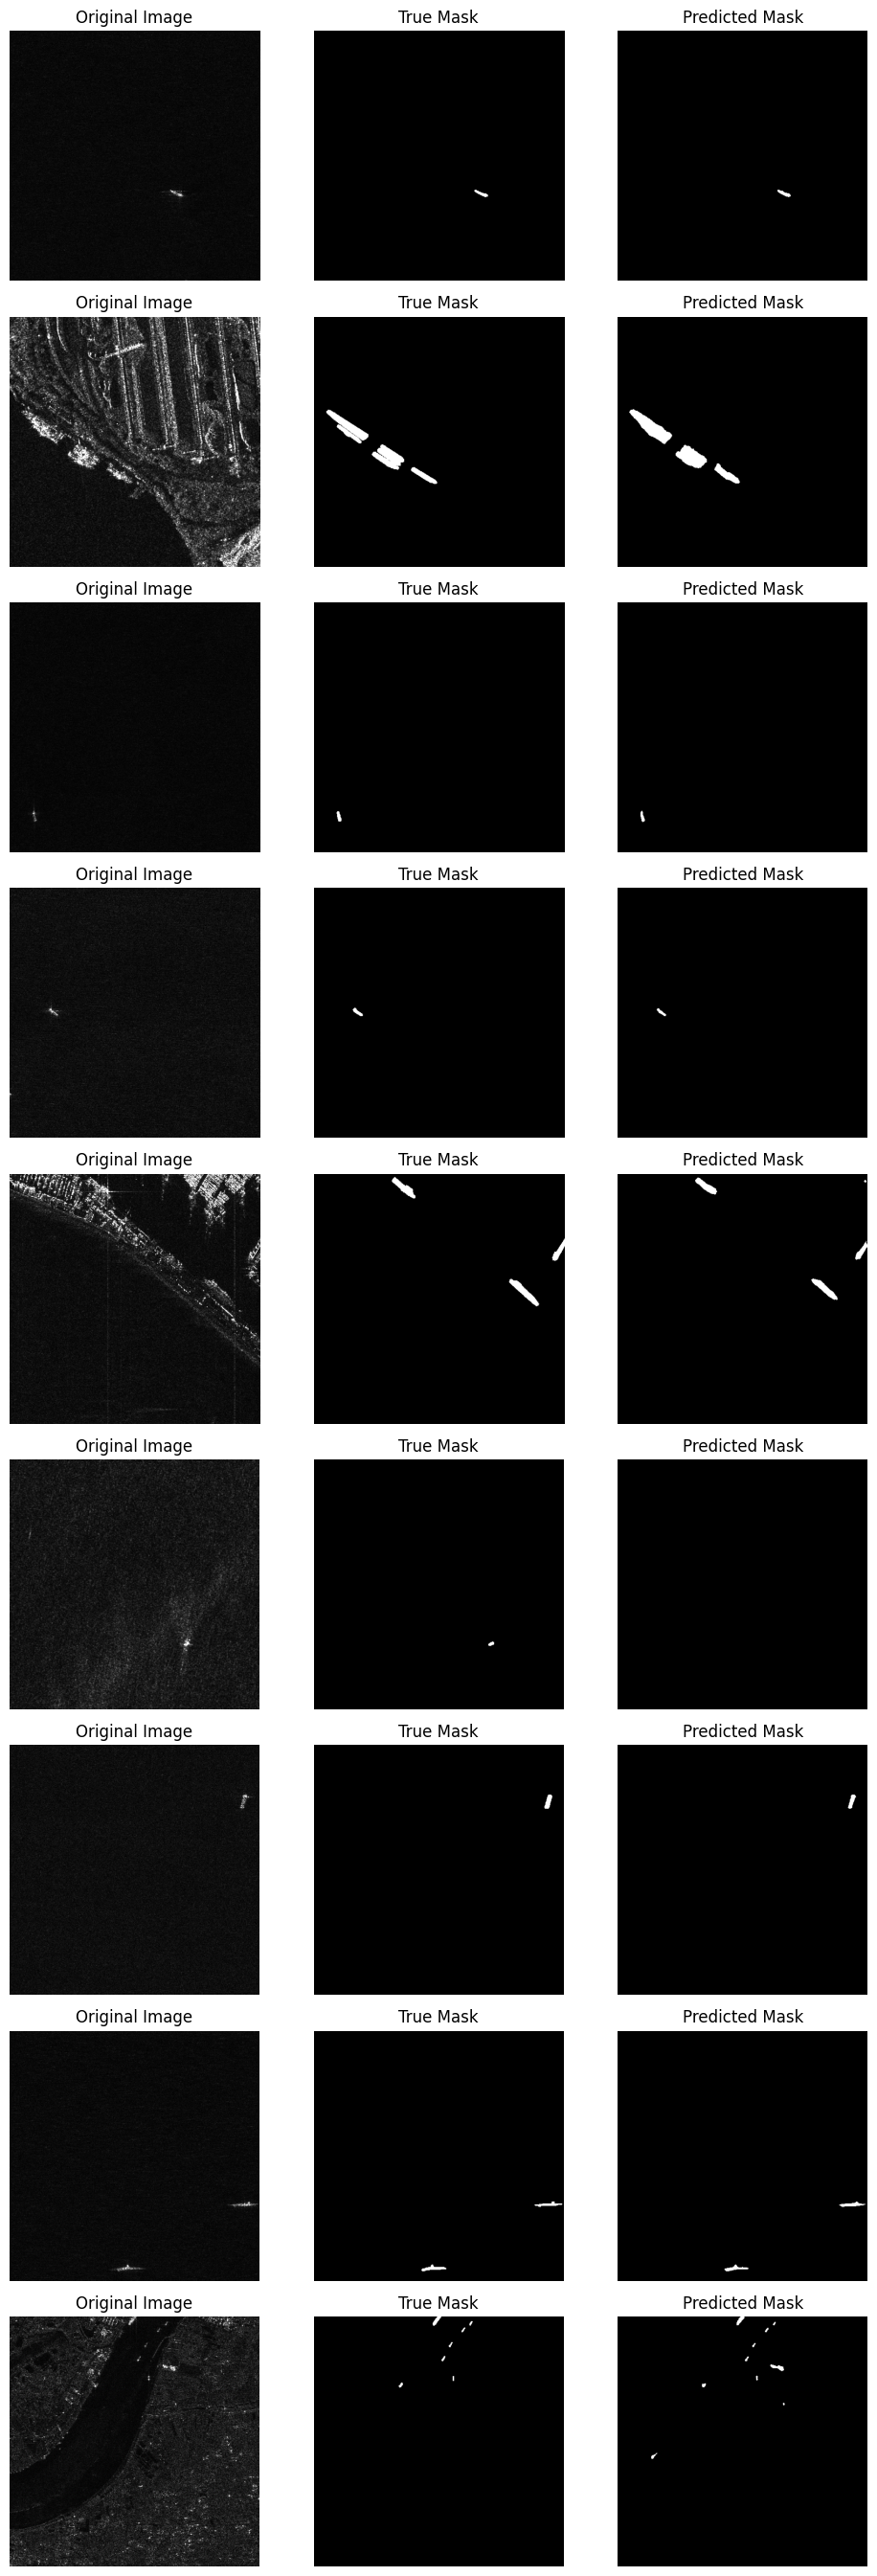

In [ ]:
def visualize_predictions(image_batch, mask_batch, prediction_batch, num_samples=3):
    # Ensure that the number of samples does not exceed the batch size
    num_samples = min(num_samples, len(image_batch))

    # Randomly select indices for the images to display
    indices = np.random.randint(0, len(image_batch), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    for i, idx in enumerate(indices):
        axs[i, 0].imshow(image_batch[idx, :, :, 0], cmap='gray')
        axs[i, 0].title.set_text('Original Image')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask_batch[idx, :, :, 0], cmap='gray')
        axs[i, 1].title.set_text('True Mask')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(prediction_batch[idx, :, :, 0] > 0.5, cmap='gray')  # Thresholding prediction
        axs[i, 2].title.set_text('Predicted Mask')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Assume 'predictions' contains the model's outputs for the corresponding test images
visualize_predictions(test_images_loaded, test_masks_loaded, predictions, 9)